# Problème

On a une matrice QUBO de taille n, qui peut se traduire par la fonction d'énergie suivante:

$x\in{\{0,1\}^n}$ Vecteur de bits et  $q_{ij}\in \mathbb{R}$ Élément de la matrice Qubo

$$H(x) = \sum^n_i{q_{ii} x_i} + \sum^n_{i<j}{q_{ij} x_ix_j}$$


L'objectif est de minimiser $H(x)$, ce qui équivaut à trouver $x_0$ tel que 

$$\forall x \in {\{0, 1\}^n}, x \ne x_0 \implies  H(x) > H(x_0)$$

## Résolution avec un QPU Pasqal

Les ordinateurs de Pasqal permettent l'évolution du Hamiltonien d'un système quantique vers un Hamiltonien final.

On cherche donc à obtenir un Hamltonien similaire au $H(x)$ vu précédemment.

On peut obtenir un Hamiltonien de la forme suivant sur un QPU de Pasqal:

$$
\hbar\sum_i{(\frac{\Omega}{2}\sigma^x_i - \delta \^n_i)} + \sum_{i<j}{\frac{C_6}{(R_{ij})^6}\^n_i\^n_j}
$$

La première somme correspond à l'énergie des atomes seuls, la deuxième correspond à l'énergie des interactions entre les atomes.

Ce notebook traite **uniquement** de la deuxième somme. On cherchera à obtenir l'égalité suivante:

$$
\sum_{i<j}{\frac{C_6}{(R_{ij})^6}\^n_i\^n_j} =  \sum_{i<j}{q_{ij} x_ix_j}$$
$$


$C_6$ est le coefficient d'interaction du QPU, sa valeur est constante.

$R_{ij}$ est la distance entre les atomes $i$ et $j$.

## Objectif du notebook

### Placer des atomes dans un espace 2D, de manière à modéliser approximativement les interactions voulues sur un QPU.
Le $\mu m$ est l'unité des coordonnées

Les atomes doivent être placés à moins de $50\mu m$ du centre, et chaque atome doit se trouver à plus de $4\mu m$ des autres atomes.

Les atomes qui interagissent entre eux doivent être séparés par une distance $R_{ij}$ (cf. formule précédente)

In [3]:
# Bibliothèques utilitaires
import numpy as np  # Opérations sur arrays
import matplotlib.pyplot as plt  # Affichage de graphiques
from scipy.spatial.distance import pdist, squareform, cdist  # Calcul de distances

# Fonctions locales
from src.utils import max_outer, clamp
#from src.qubo_to_register import (
#    hard_mapping,
#)  # Modélisation trop spécifique au problème actuel
from src.check_register import RegisterChecker  # Classe pour vérifier

Matplotlib is building the font cache; this may take a moment.


In [4]:
def hard_mapping(
    n_lran : int, n_hran : int, max_dist : float = 50, blockade : float = 13.253644930249399, interaction_coeff : float = 5420158.53, target_weight : float = -1
):
    """ Specific implementation of qubo to register conversion, only works for Sopra Germany's qubo matrices

    Args:
        n_lran : number of LRANs
        n_hran : number of HRANs
        max_dist : Maximum allowed distance between points and (0, 0). Defaults to 50.
        blockade : Blockade radius. Defaults to 13.253644930249399.
        interaction_coeff : C6 in the formula. Defaults to 5420158.53.
        target_weight : Weight between incompatible qubits. Defaults to -1.

    Returns:
        _type_: _description_
    """
    max_dist -= blockade

    # Minimal distance between atoms
    min_dist_between_atoms = 4

    
    # Calculate optimal distance, following the formula:
    # Rij = (C_6 / weight)^(1/6)
    if target_weight > 0:
        inter_dist = clamp(
            (interaction_coeff / target_weight) ** (1 / 6),
            lower=4,
            upper=blockade,
        )
    # Check the number of lran that can be put on the outer circle
    max_lran = max_outer(max_dist, blockade, inter_dist)
    if n_lran > 2 * max_lran - 1:
        print(f"Cannot create more than {2 * max_lran - 1} lran")

    # Setup layers
    layers = []
    while n_lran > 0 and max_dist >= 0:
        layers.append((min(max_lran, n_lran), max_dist))
        max_dist -= 2 * blockade
        n_lran -= max_lran
        max_lran = max_outer(max_dist, blockade, inter_dist)

    # Place qubits on the array
    coords = []
    for n_lran, max_dist in layers:
        for i in range(n_lran):
            angle = i * 2 * np.pi / n_lran
            x = np.cos(angle) * (max_dist - 1)
            y = np.sin(angle) * (max_dist - 1)
            #coords.append([x, y])  # for visual purposes only

            #Maximum hran that can be put around the point of coordinate (x,y)  
            max_hran = (2*np.pi*blockade)//min_dist_between_atoms
            if n_hran > max_hran :
                #raise ValueError('Too much hran')
                print('Too much hran')

            for j in range(min(n_hran, max_hran)):
                jangle = angle + j * 2*np.pi / n_hran + np.pi / 2
                xj = x + np.cos(jangle) * inter_dist
                yj = y + np.sin(jangle) * inter_dist
                coords.append([xj, yj])
    return coords

#### Initialisation de l'évaluateur de mappings (Placements d'atomes)

In [5]:
with open("matrices/example.pkl", "rb") as f:
    qubo = np.load(f)
# plt.matshow(qubo)

check = RegisterChecker(qubo)

#### Exemple d'implémentation - Mapping spécifique au problème simplifié
Ne nécessite pas la matrice qubo en entrée mais ne fonctionne que pour un cas très spécifique

Faites `F12` ou regardez dans le fichier `src/qubo_to_register.py` pour voir le code

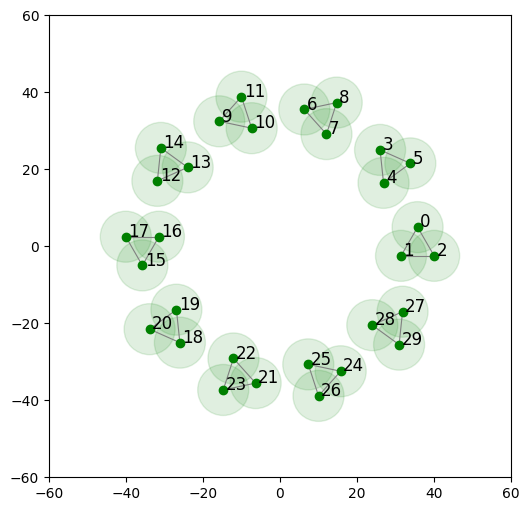

In [6]:
mapping = hard_mapping(
    n_lran=10,
    n_hran=3,
    blockade=check.blockade,
    interaction_coeff=check.C6,
    target_weight=qubo[0][1],
)
#check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

#### Exemple d'implémentation - Boucle d'optimisation avec Scipy
Fonctionne en théorie pour n'importe quel problème QUBO, mais ne fonctionne juste pas

In [7]:
from scipy.optimize import minimize


def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    coords_dist = pdist(new_coords)
    too_close = False  # or np.min(coords_dist) < 4
    new_Q = squareform(
        check.C6 / coords_dist**6
    )  # + cdist(new_coords, np.zeros(shape))
    new_Q = new_Q - np.diag(np.diag(new_Q))
    too_far = False  # or np.max(cdist(new_coords, np.zeros(shape))) > 50
    diff_norm = np.linalg.norm(new_Q - Q - np.diag(np.diag(Q)))
    return diff_norm * (1 + too_far | too_close)


shape = (len(qubo), 2)
costs = []
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(qubo, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

mapping = np.reshape(res.x, (len(qubo), 2))

Score : 32.63326778381239 %


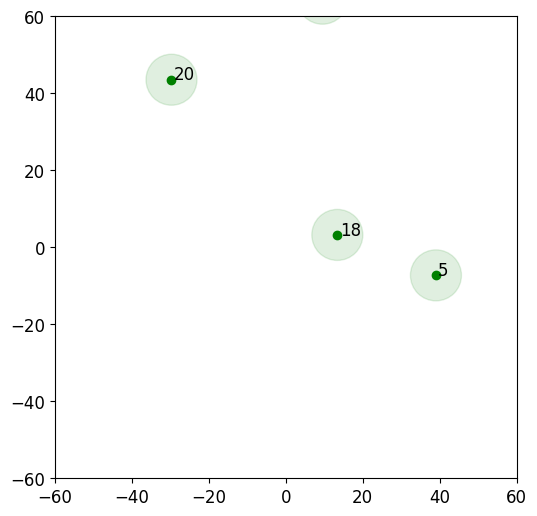

In [8]:
check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

In [9]:
np.set_printoptions(formatter={"float_kind": "{:.1f}".format}, linewidth=999)
print(mapping)

[[-19.8 103.0]
 [-222.3 39.0]
 [-101.9 -2.2]
 [110.5 103.8]
 [-79.2 281.9]
 [39.0 -7.3]
 [205.1 -47.7]
 [129.6 404.5]
 [9.6 64.6]
 [358.2 110.7]
 [110.0 121.8]
 [71.3 74.0]
 [-2.1 118.7]
 [-2.7 113.8]
 [423.2 -56.3]
 [71.3 428.1]
 [316.6 -26.5]
 [213.1 58.2]
 [13.4 3.2]
 [-19.4 167.8]
 [-29.7 43.5]
 [158.9 29.1]]


### Votre implémentation!
Implémentez une fonction qui place les atomes selon les contraintes spécifiées. Pour résumer:
- Distance(Atome, (0,0)) < 50
- Ditance(Atome, Atome) > 4
- Si les atomes $a_i$ et $a_j$ interagissent:
  > Distance($a_i$, $a_j$) $\thickapprox$ ($R_{ij}$)
- Sinon:
  > Distance($a_i$, $a_j$) > $blockade$

$$
R_{ij} = \left(\frac{C_6}{qubo[i][j]}\right)^{\frac{1}{6}}
$$

La manière d'implémenter la fonction est libre, vous pouvez vous baser sur mon implémentation (hard_mapping), l'implémentation avec l'optimiseur scipy ou même utiliser une bibliothèque externe pour vous faciliter la tâche.

In [10]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import time

def distance_matrix(positions):
    return squareform(pdist(positions))

def penalty_function(positions, qubo, C6, blockade, n, max_dist_to_origin, min_dist_interatoms):
    positions = positions.reshape((n, 2))
    dist_matrix = distance_matrix(positions)
    penalty = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist_ij = dist_matrix[i, j]
            if qubo[i, j] != 0:
                Rij = (C6 / qubo[i, j])**(1/6)
                penalty += (dist_ij - Rij)**2
            else:
                if dist_ij < blockade:
                    penalty += (blockade - dist_ij)**2
    
    dist_to_origin = np.linalg.norm(positions, axis=1)
    penalty += np.sum((dist_to_origin - max_dist_to_origin) * (dist_to_origin >= max_dist_to_origin)**2)
    penalty += np.sum((min_dist_interatoms - dist_matrix[dist_matrix < min_dist_interatoms])**2)
    
    return penalty

def place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms):
    start_time = time.time()
    n = qubo.shape[0]
    
    # Initialiser les positions dans un cercle de rayon 25
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    initial_positions = 25 * np.column_stack((np.cos(angles), np.sin(angles)))

    result = minimize(penalty_function, initial_positions.flatten(), args=(qubo, C6, blockade, n, max_dist_to_origin, min_dist_interatoms), method='L-BFGS-B')
    
    print("Time elapsed : ", time.time() -start_time)
    
    if result.success:
        final_positions = result.x.reshape((n, 2))
        return final_positions
    else:
        raise ValueError("Optimization failed")


In [11]:
#Exemple
qubo = np.array([[0, 1, 0.5], [1, 0, 0.2], [0.5, 0.2, 0]])
C6 = 5420158.53
blockade = 13.253644930249399
max_dist_to_origin = 50
min_dist_interatoms = 4

positions = place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)
print("Positions des atomes :")
print(positions)

Time elapsed :  0.021379947662353516
Positions des atomes :
[[7.4 0.5]
 [-3.2 8.4]
 [-4.1 -8.9]]


Time elapsed :  0.017460346221923828


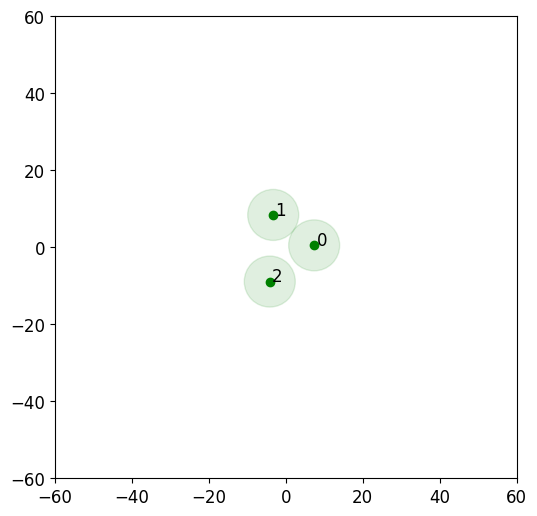

In [12]:
mapping = place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)

#check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

In [13]:
# Cette fonction sera appelée par la cellules de tests
# Vous pouvez changer les arguments de la fonction comme vous voulez, il faudra simplement adapter la cellule de tests plus tard
def find_mapping(qubo, C6=check.C6, blockade=check.blockade) -> np.array:
    # FIXME
    return place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)
  # TODO Ceci est un placeholder, il faut bien évidemment changer la valeur de retour

In [14]:
# Test rapide pour voir le mapping sous forme de matrice QUBO
check.map_to_qubo(find_mapping(check.qubo))

Time elapsed :  0.25095033645629883


array([[0.0, 360.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.8],
       [360.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1],
       [0.1, 0.8, 0.0, 360.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.1, 360.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.1, 0.8, 0.0, 360.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.1, 360.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.1, 0.8, 0.0, 360.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 360.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0,

#### Tests

Génération aléatoire de matricees à tester

In [15]:
# Génération de matrice QUBO aléatoire\
# size = nb de qubits
def generate_qubo(size=18):
    v = np.random.randint(1, 20, (size * (size - 1)) // 2) * np.random.rand()
    return squareform(v)


def save_matrix(mat, name):
    with open(
        f"./matrices/{name}.pkl", "wb"
    ) as f:  # Ajout de la matrice dans le dossier matrices/
        np.save(f, mat)


smol_random = generate_qubo(10)
print(smol_random)
save_matrix(smol_random, name="random")

[[0.0 10.5 6.2 9.9 4.3 11.1 3.7 0.6 0.6 0.6]
 [10.5 0.0 1.9 9.3 0.6 9.3 2.5 4.9 9.3 8.6]
 [6.2 1.9 0.0 0.6 5.6 11.1 5.6 9.9 3.1 7.4]
 [9.9 9.3 0.6 0.0 10.5 9.9 4.9 1.2 1.9 7.4]
 [4.3 0.6 5.6 10.5 0.0 5.6 8.6 6.8 1.2 3.7]
 [11.1 9.3 11.1 9.9 5.6 0.0 6.2 6.8 11.1 11.1]
 [3.7 2.5 5.6 4.9 8.6 6.2 0.0 3.1 11.1 4.9]
 [0.6 4.9 9.9 1.2 6.8 6.8 3.1 0.0 4.9 11.1]
 [0.6 9.3 3.1 1.9 1.2 11.1 11.1 4.9 0.0 1.2]
 [0.6 8.6 7.4 7.4 3.7 11.1 4.9 11.1 1.2 0.0]]


Cellule de test

Time elapsed :  0.26204895973205566
Score : 76.126885649869 %


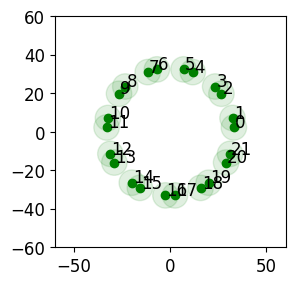

Time elapsed :  0.30948925018310547
Score : 82.89156478663658 %


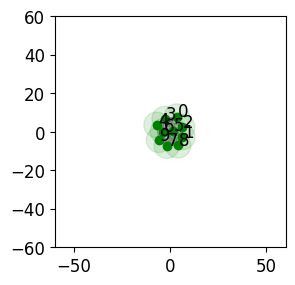

In [16]:
import os
from os.path import join, isfile

MANUAL_PICK = False  # True si on veut choisir les matrices à tester
SHOW_GRAPHS = True  # True si on veut voir le graphique pour chaque matrice testée
PATH = "./matrices/"


test_matrices = [
    join(PATH, f) for f in os.listdir("./matrices") if isfile(join(PATH, f))
]

if len(test_matrices) == 0 or MANUAL_PICK:
    test_matrices = ["random.pkl"]  # Choix manuel des matrices à tester
    test_matrices = [
        join(PATH, f) for f in test_matrices
    ]  # Formattage du chemin vers les matrices

for matrix_file in test_matrices:
    with open(matrix_file, "rb") as f:
        check.qubo = np.load(f)
    mapping = find_mapping(check.qubo)
    check.evaluate_register(mapping)
    if SHOW_GRAPHS:
        check.show_register(mapping, shape=(3, 3))